# Notebook для построения и оценки модели ML для распознавания цифр.

Список библиотек

In [9]:
import os
import sys

from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve

Для начала надо обработать данные. Для этого представляем картинки 28x28 в виде одного массива, где каждая ячейка - один пиксель из картинки. В качестве значений ячейки выступит следующее число: берем цвет картинки(так как картинки черно-белые, можно взять из rgb только первый параметр), затем нормируем(делим на 255, получаем число от 0 до 1) и вычитаем из единицы полученное значение, то есть, белому соответствует значение 0.0, черному - 1.0, а оттенкам серого - где-то между.

In [3]:
train_data = pd.DataFrame()

im_count = 1
train_data_size = sum([len(os.listdir(f'TrainingImages/{digit}')) for digit in range(10)])

for digit in range(10):
    item = {}
    images_dirs = os.listdir(f'TrainingImages/{digit}')
    
    for image_dir in images_dirs:
        im = Image.open(f'TrainingImages/{digit}/{image_dir}')

        px = im.load()
        for x in range(im.size[0]):
            for y in range(im.size[1]):
                if f'{x}_{y}' in item.keys():
                    item[f'{x}_{y}'].append(1 - px[x, y][0] / 255)
                else:
                    item[f'{x}_{y}'] = [1 - px[x, y][0] / 255]
    
        if 'digit' in item.keys():
            item['digit'].append(digit)
        else:
            item['digit'] = [digit]

        sys.stdout.write(f'Обработка данных выполнена на {round(im_count * 100 / train_data_size, 2)}%\r')
        im_count += 1

    item = pd.DataFrame(item)
    train_data = pd.concat([train_data, item])

In [4]:
train_data = train_data.sample(frac=1)
train_data

,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,27_19,27_20,27_21,27_22,27_23,27_24,27_25,27_26,27_27,digit
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
4893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
4715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
3199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
3905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [5]:
test_data = pd.DataFrame()

im_count = 1
test_data_size = sum([len(os.listdir(f'TestImages/{digit}')) for digit in range(10)])

for digit in range(10):
    item = {}
    images_dirs = os.listdir(f'TestImages/{digit}')
    
    for image_dir in images_dirs:
        real_im = Image.open(f'TestImages/{digit}/{image_dir}')
        
        real_px = real_im.load()
        for x in range(real_im.size[0]):
            for y in range(real_im.size[1]):
                if f'{x}_{y}' in item.keys():
                    item[f'{x}_{y}'].append(1 - real_px[x, y][0] / 255)
                else:
                    item[f'{x}_{y}'] = [1 - real_px[x, y][0] / 255]
    
        if 'digit' in item.keys():
            item['digit'].append(digit)
        else:
            item['digit'] = [digit]

        sys.stdout.write(f'Обработка данных выполнена на {round(im_count * 100 / test_data_size, 2)}%\r')
        im_count += 1

    item = pd.DataFrame(item)
    test_data = pd.concat([test_data, item])

In [6]:
test_data

,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,27_19,27_20,27_21,27_22,27_23,27_24,27_25,27_26,27_27,digit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
1005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
1006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
1007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


In [7]:
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]

X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

Найдем оптимальные параметры Градиентного Бустинга от XGBoost при помощи Байесовской оптимизации.

Модель и способ отбора параметров я выбрал на свой вкус. Тем более, эти варианты точно не худшие.

In [10]:
param_space = {
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(5, 10),
    'learning_rate': Real(0.01, 0.4),
    'gamma': Real(0, 10),
    'subsample': Real(0.1, 1),
    'min_child_weight': Real(0, 1)
}

searcher = BayesSearchCV(XGBClassifier(objective='multi:softmax'), param_space, n_iter=20, cv=5)
searcher.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                             'learning_rate': Real(low=0.01, high=0.4, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=5, high=10, prior='uniform', transform='normalize'),
                             'min_child_weight': Real(low=0, high=1, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=200, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.1, high=1, prior='uniform', transform='normalize')})

In [28]:
searcher.best_params_

OrderedDict([('gamma', 0.0),
             ('learning_rate', 0.28332998582415403),
             ('max_depth', 6),
             ('min_child_weight', 0.0),
             ('n_estimators', 200),
             ('subsample', 1.0)])

In [27]:
model = searcher.best_estimator_
print(f'Лучшая оценка кросс-валидации: {searcher.best_score_}')

Лучшая оценка кросс-валидации: 0.977479500720152


Ура, модель обучилась! И очень даже хорошо: показатель CVScore почти 98%. Заметим, что почти параметры почти как из коробки(это к качеству модели от XGBoost). Теперь оценим ее по некоторым другим метрикам качества. Стоит отметить, что для данной задачи наиболее важной метрикой будет являться точность. Смысла смотреть f1-score немного, так как классы более менее равномощные(по этой причине, можно использовать как micro-averaging, так и macro-averaging), но для полноты картины добавлю.

In [12]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

In [13]:
conf_m = confusion_matrix(y_test, y_pred)
conf_m

array([[ 971,    0,    0,    0,    0,    1,    3,    1,    3,    1],
       [   0, 1122,    3,    3,    0,    1,    1,    1,    4,    0],
       [   3,    0, 1011,    5,    1,    0,    1,    5,    5,    1],
       [   0,    0,    5,  991,    0,    3,    0,    6,    4,    1],
       [   1,    0,    4,    1,  957,    0,    4,    0,    2,   13],
       [   2,    0,    0,    7,    0,  869,    6,    2,    4,    2],
       [   6,    3,    0,    0,    1,    4,  939,    0,    5,    0],
       [   1,    1,   11,    1,    1,    0,    0, 1009,    1,    3],
       [   4,    0,    3,    0,    1,    3,    2,    1,  956,    4],
       [   5,    5,    1,    4,    6,    1,    0,    4,    2,  981]])

In [15]:
metrics_scores = pd.DataFrame({
    'accuracy': [accuracy_score(y_test, y_pred)],
    'f1_score': [f1_score(y_test, y_pred, average='macro')],
})

metrics_scores

,accuracy,f1_score
0,0.9806,0.98048


Полученные оценки модели радуют. Можно было бы уже на этом приступать к практической проверке, но для разнообразия, посмотрим еще некоторые оценки.

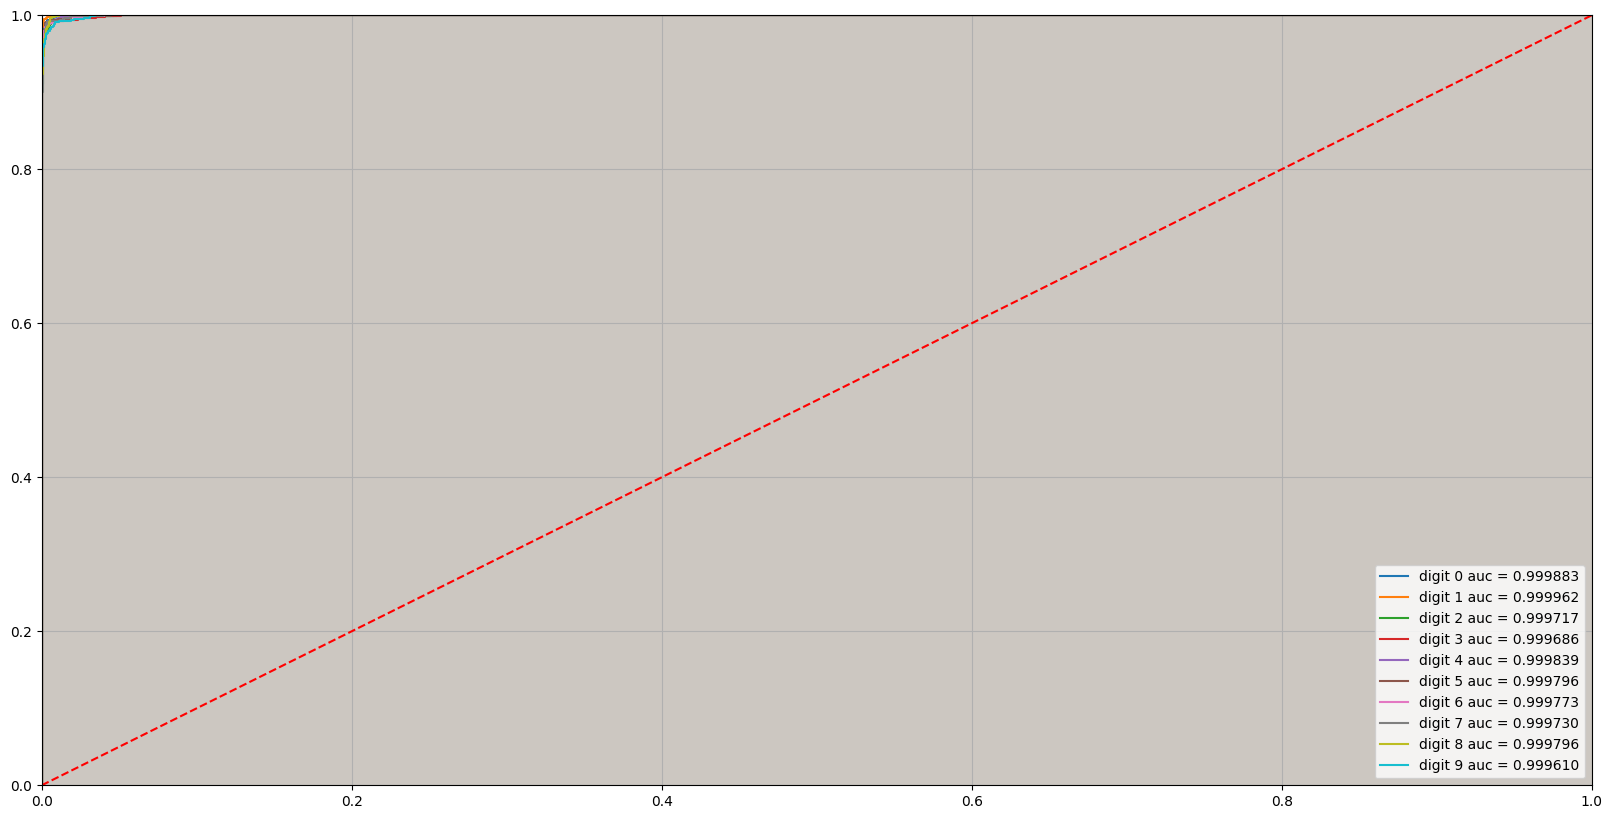

In [31]:
plt.figure(figsize=(20, 10))

for i in range(10):
    y_test_ova = y_test.copy()
    y_test_ova[y_test != i], y_test_ova[y_test == i] = -1, 1
    
    fpr, tpr, _ = roc_curve(y_test_ova, y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'digit {i} auc = {auc(fpr, tpr):.6f}')
    plt.fill_between(fpr, tpr, np.zeros_like(tpr), alpha=0.05)

plt.plot([0, 1], [0, 1], linestyle='--', color='red')

plt.axis((0, 1, 0, 1))
plt.grid(True)
plt.legend(loc='lower right');

ROC AUC дает почти идеальные результаты для всех цифр. Это означает, что модель склонна давать оценки вероятности близкие к 0 и 1. Это, конечно, хорошо, так как модель в основном верно распознает цифры, хотя иногда модели бы не помешала некоторая неуверенность(иногда люди пишут очень неразборчиво). Посмотрим теперь на калибровку модели.

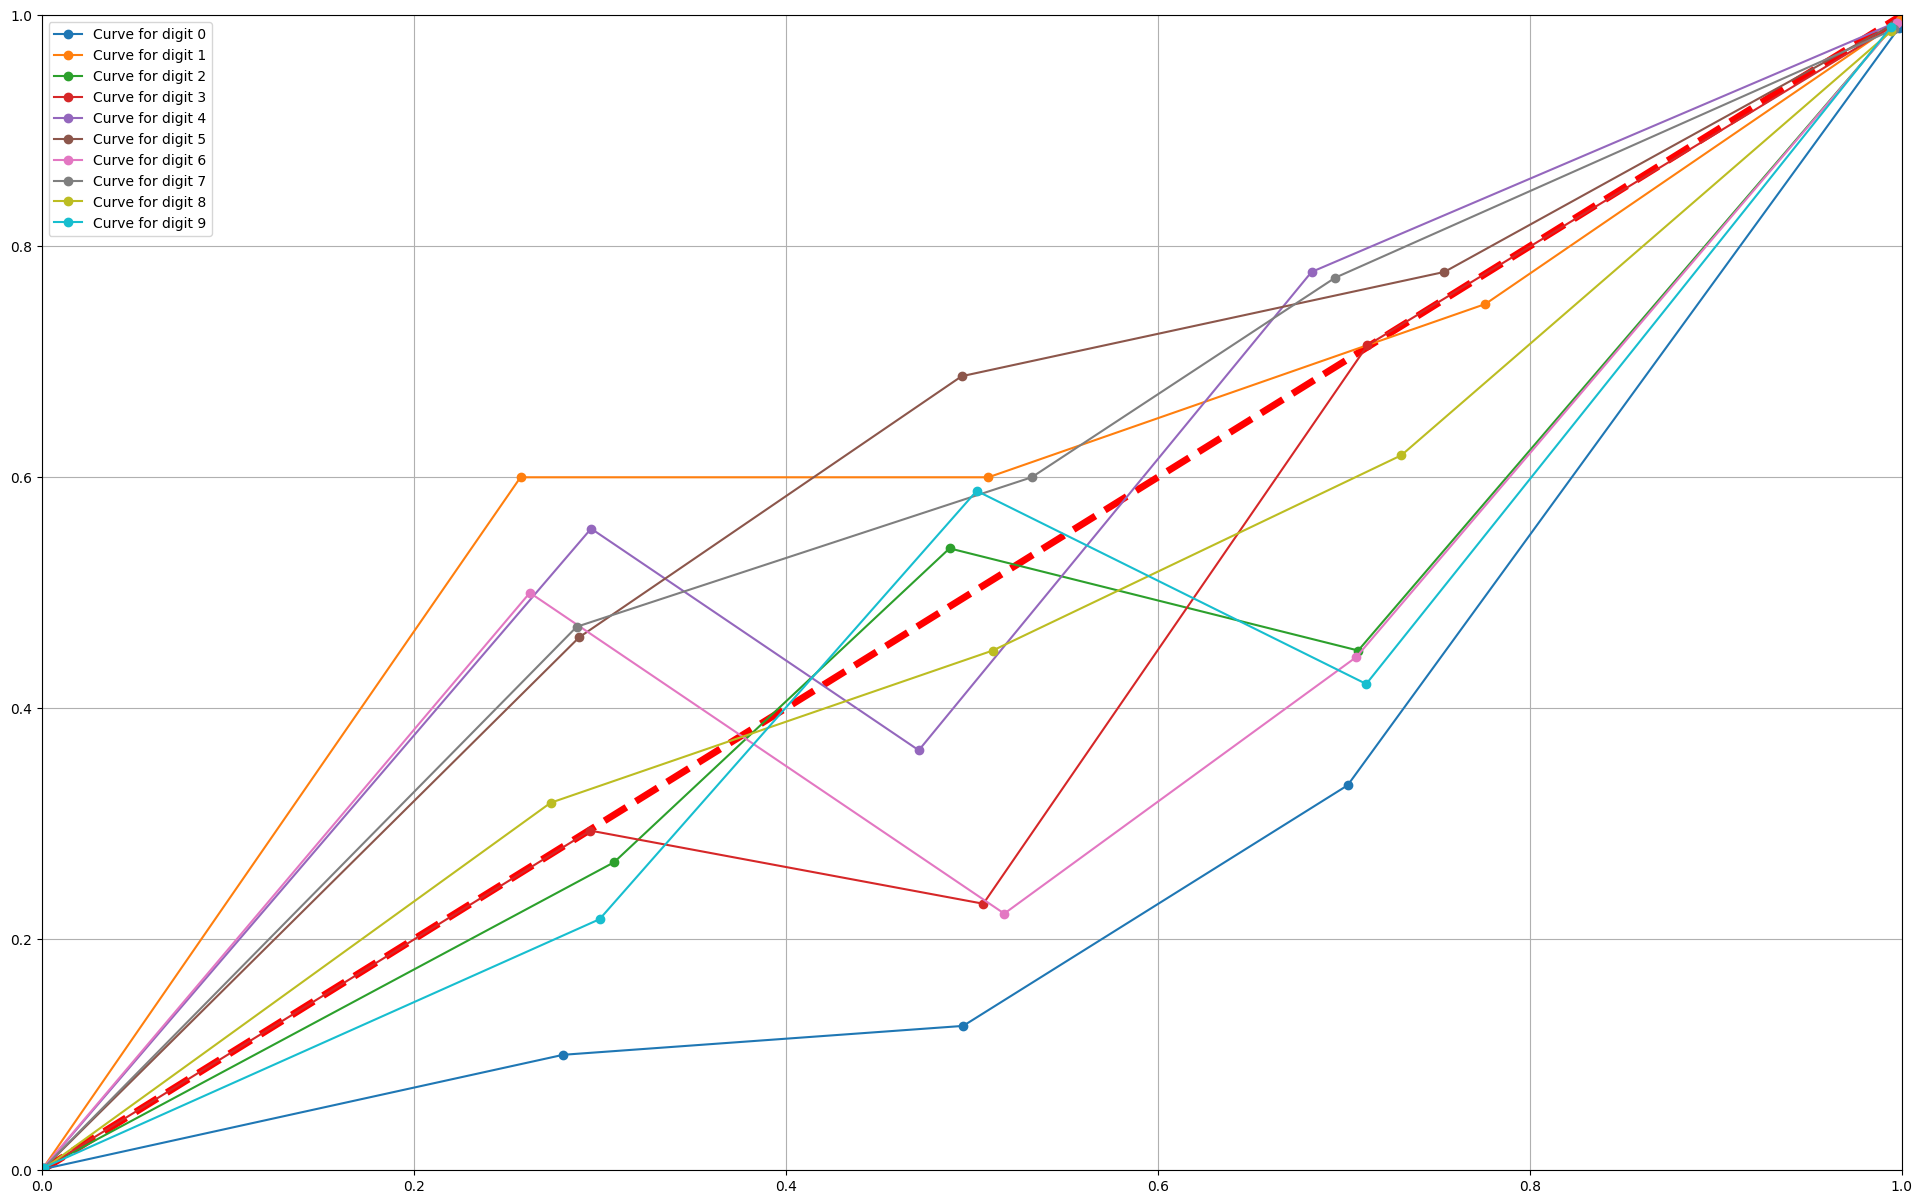

In [32]:
plt.figure(figsize=(24, 15))
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=5, color='red')

for i in range(10):
    y_test_ova = y_test.copy()
    y_test_ova[y_test != i], y_test_ova[y_test == i] = -1, 1
    
    y_pred_proba_ova = y_pred_proba[:, i].copy()
    
    true_prob, pred_prob = calibration_curve(y_test_ova, y_pred_proba_ova, n_bins=5)
    plt.plot(pred_prob, true_prob, marker='o', label=f'Curve for digit {i}')

plt.grid(True)
plt.axis((0, 1, 0, 1))
plt.legend(loc='upper left');

Из графиков видно, что модель почти "неправильным" цифрам не дает вероятность около 1 и "правильным" не дает около 0. Однако, для некоторых цифр модель плохо прогнозирует промежуточные вероятности. Например, с нулем какая-то фееричная ситуация: алгоритм хорошо предсказывает 0 или 1, но слишком уверен в промежуточных результатах, хотя стоило бы усомниться. Для цифры 5 обратная ситуация: можно было бы немного завышать промежуточную вероятность.

В целом, для этой задачи нам не сильно нужна идеально откалиброванная модель - главное, чтобы как можно больше было правильных классификаций. Да и другие метрики качества дают приличные оценки. Поэтому на некоторые проблемы с вероятностями, можно закрыть глаза. 

Теперь посмотрим, как модель предсказывает цифры не из датасета. 

На деле, далеко не всегда хорошо. Большая часть цифр в тренировочных данных находится близко к "центру" картинок, то есть, отступы от краев плюс-минус одинаковы. Поэтому нужно центрировать данные: находим наименьший прямоугольник, полностью содержащий цифру, и перемещаем его в центр. 

Допустим, эту проблему решили. Другая проблема: модель плохо распознает слишком маленькие (относительно всего изображения) или большие цифры. Эту проблему можно попробовать решить на программном уровне(ввести, например, фиксированный размер цифр, но тогда появятся другие проблемы, например, растягивание маленьких цифр и сужение больших, отчего их качество будет хуже изначального) или набором новых данных с такими ситуациями.

И последняя проблема, модель плохо работает с "плохими" цифрами. Алгоритм выявил некоторые примечательные фичи для каждой цифры. Это, конечно, очевидно, но из-за выбора этих фич, модель может иногда путать цифры между собой(например, если завить хвост у девятки, то достаточно часто модель может дать ответ 8). Эта проблема в полной мере не решается(увеличение датасета может только улучшить ситуацию). 

Суммируя, сама модель способна хорошо распознавать центрированные, относительно аккуратно написанные, цифры умеренного размера. *Именно для приложения* не обязательны центрированные цифры, она их сама центрирует.

Ниже приведен пример работы программы.

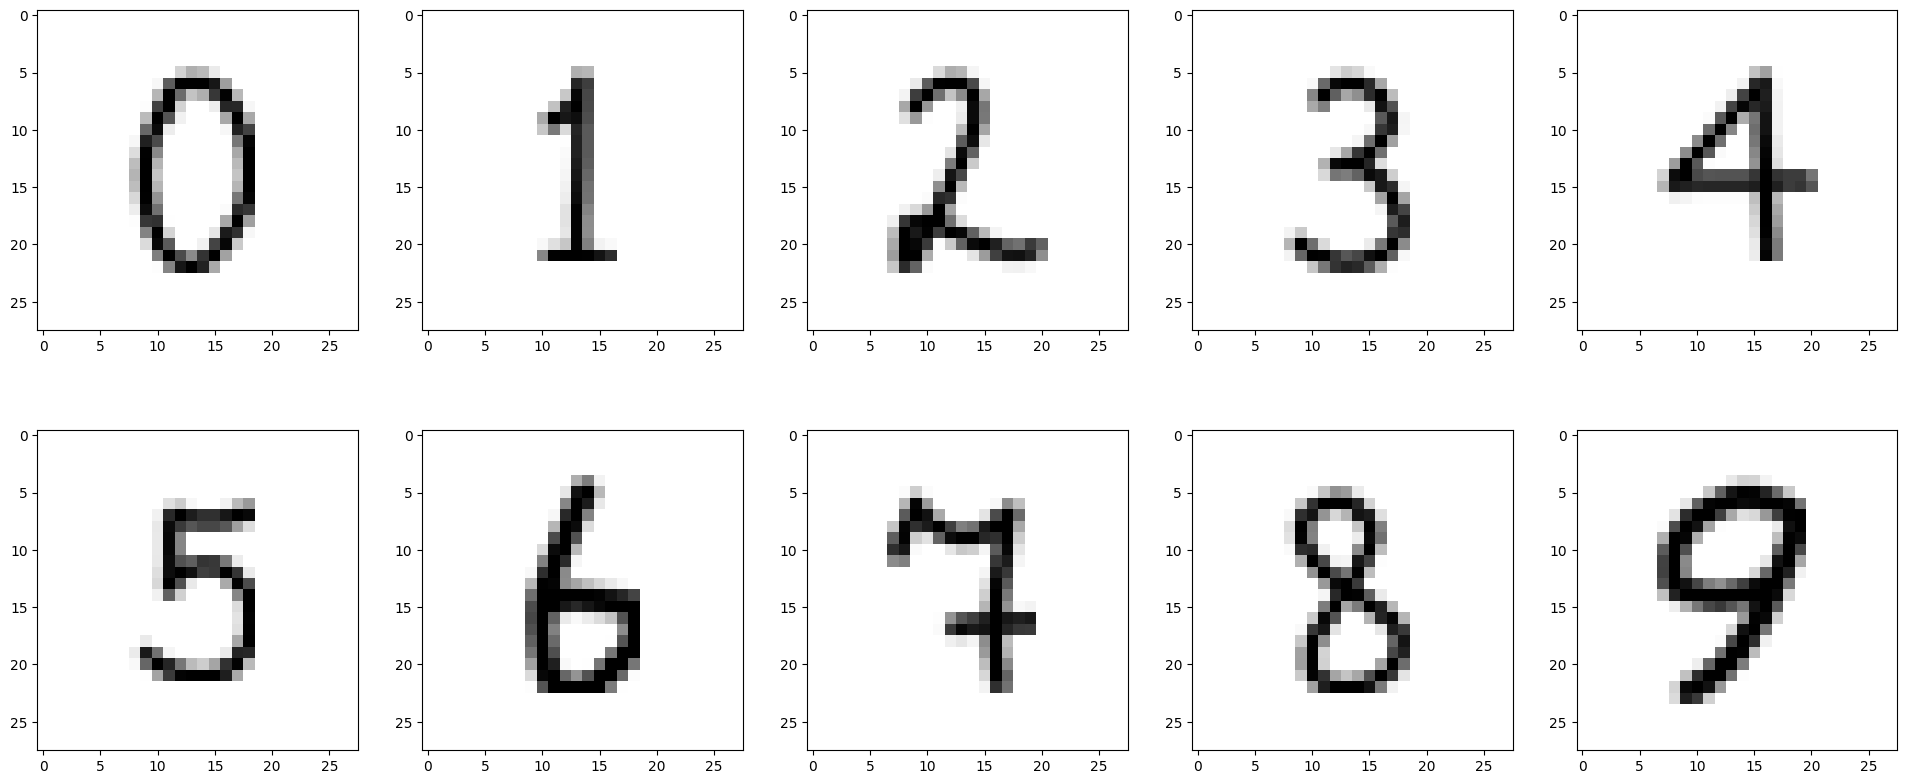

In [42]:
plt.figure(figsize=(24, 10))

item = {}
for i in range(10):
    real_im = Image.open(f'MyDigits/{i}.png')
    real_im = real_im.resize((28, 28))
    real_px = real_im.load()
    
    # Описание цифры и центрирование
    vert_line, horiz_line = [27, 0], [27, 0]
    for x in range(real_im.size[0]):
        for y in range(real_im.size[1]):
            horiz_line = [min(x, horiz_line[0]), max(x, horiz_line[1])] if real_px[x, y][0] != 255 else horiz_line 
            vert_line = [min(y, vert_line[0]), max(y, vert_line[1])] if real_px[x, y][0] != 255 else vert_line
    
    new_im = Image.new("RGBA", (28, 28), "#fff")
    paste_im = real_im.crop((horiz_line[0], vert_line[0], horiz_line[1], vert_line[1]))
    start_coord = (28 - (horiz_line[1] - horiz_line[0])) // 2, (28 - (vert_line[1] - vert_line[0])) // 2
    new_im.paste(paste_im, start_coord)
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(new_im)
    
    # Теперь уже можно перевести картинку в табличный вид 
    new_px = new_im.load()
    for x in range(new_im.size[0]):
        for y in range(new_im.size[1]):
            if f'{x}_{y}' in item.keys():
                item[f'{x}_{y}'].append(1 - new_px[x, y][0] / 255)
            else:
                item[f'{x}_{y}'] = [1 - new_px[x, y][0] / 255]

im_data = pd.DataFrame(item)

In [43]:
prediction = model.predict(im_data)
proba_prediction = model.predict_proba(im_data)
for i in range(10):
    print(f'В картинке {i} модель распознала {prediction[i]}, со степенью уверенности {proba_prediction[i, prediction[i]] * 100:.2f}%')

В картинке 0 модель распознала 0, со степенью уверенности 99.79%
В картинке 1 модель распознала 1, со степенью уверенности 99.92%
В картинке 2 модель распознала 2, со степенью уверенности 98.55%
В картинке 3 модель распознала 3, со степенью уверенности 99.97%
В картинке 4 модель распознала 4, со степенью уверенности 99.99%
В картинке 5 модель распознала 5, со степенью уверенности 99.66%
В картинке 6 модель распознала 6, со степенью уверенности 99.71%
В картинке 7 модель распознала 7, со степенью уверенности 99.88%
В картинке 8 модель распознала 8, со степенью уверенности 94.98%
В картинке 9 модель распознала 9, со степенью уверенности 96.67%


Видим, что модель в данном примере, дает правильные и достаточно уверенные предсказания.